# Prompt injection detection project

## install prerequisites

In [1]:
!pip install kaggle


## Imports

In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


## Const Vars

In [4]:
N_BINS: int = 100
KAGGLE_USERNAME:str="arielzilber"
KAGGLE_KEY:str="7f0cfa2d136af50998e08583c84cc892"
DATASET_PATH="/content/datasets/prompt-security-dataset"
BETA=2

## Helper Function

In [5]:
def plot_bin_graph(df: pd.DataFrame, *, n_bins: int = N_BINS):
    perplexity_counts = df['Perplexity'].value_counts()
    # Calculate statistics for Perplexity
    min_perplexity = df['Perplexity'].min()
    mu_perplexity = df['Perplexity'].mean()
    sigma_perplexity = df['Perplexity'].std()

    # Calculate statistics for Length
    min_length = df['Length'].min()
    mu_length = df['Length'].mean()
    sigma_length = df['Length'].std()

    # Plotting the histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    # Plot for Perplexity
    axes[0].hist(df['Perplexity'], bins=N_BINS, color='green', log=True)
    axes[0].set_title('Perplexity - Prompts')
    axes[0].set_xlabel('Perplexity')
    axes[0].set_ylabel('Log-Frequency')
    axes[0].text(60, 1, f'min={min_perplexity}\n$\mu={mu_perplexity:.2f}$\n$\sigma={sigma_perplexity:.2f}$', fontsize=12)

    # Plot for Length
    axes[1].hist(df['Length'], bins=N_BINS, color='blue', log=True)
    axes[1].set_title('Length - Prompts')
    axes[1].set_xlabel('Length')
    axes[1].set_ylabel('Log-Frequency')
    axes[1].text(120, 1, f'min={min_length}\n$\mu={mu_length:.2f}$\n$\sigma={sigma_length:.2f}$', fontsize=12)
    plt.show()

In [6]:
def plot_dot_graph(df, *, log_scale: bool = False):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Perplexity', y='Length', color='green', alpha=0.6)

    # Title and labels
    plt.title('Perplexity vs. Seq-Len in Prompts')
    plt.xlabel('Perplexity')
    plt.ylabel('Seq-Length')
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Seq-Length')
        plt.title('PPL vs. Seq-Len in Prompts')
    # Show the plot
    plt.show()


## Download the dataset

In [7]:
# Api key for kaggle
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_KEY}
!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

#  create directory for reviews
!mkdir ./datasets
!mkdir ./datasets/prompt-security-dataset

# download the dataset from Kaggle and unzip it
!kaggle datasets download arielzilber/prompt-security-dataset -p ./datasets/prompt-security-dataset
!unzip ./datasets/prompt-security-dataset/*.zip  -d ./datasets/prompt-security-dataset/ > /dev/null
!rm ./datasets/prompt-security-dataset/*.zip
!ls -l ./datasets/prompt-security-dataset/ | tail -n 50

Dataset URL: https://www.kaggle.com/datasets/arielzilber/prompt-security-dataset
License(s): MIT
 37% 5.00M/13.5M [00:00<00:00, 20.8MB/s]
100% 13.5M/13.5M [00:00<00:00, 49.3MB/s]
total 63164
-rw-r--r-- 1 root root    86192 May 31 08:49 adv_prompts.csv
-rw-r--r-- 1 root root  2318154 May 31 08:49 boolq.csv
-rw-r--r-- 1 root root  6115115 May 31 08:49 code.csv
-rw-r--r-- 1 root root  1103049 May 31 08:49 docred.csv
-rw-r--r-- 1 root root 14506605 May 31 08:49 platypus.csv
-rw-r--r-- 1 root root  2752414 May 31 08:49 puffin.csv
-rw-r--r-- 1 root root 11904376 May 31 08:49 super_glue_squad_v2.csv
-rw-r--r-- 1 root root 25794877 May 31 08:49 tapir.csv
-rw-r--r-- 1 root root    85706 May 31 08:49 viccuna_prompts.csv


## EDA

In [8]:
df_dict = {}

### Adverserial prompts dataset

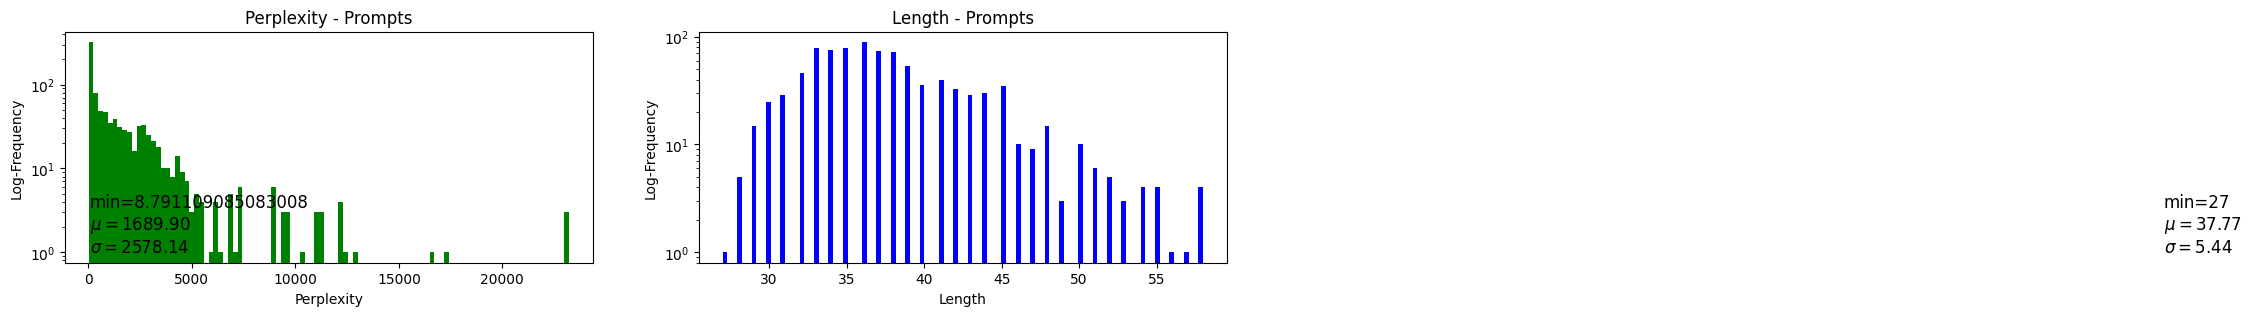

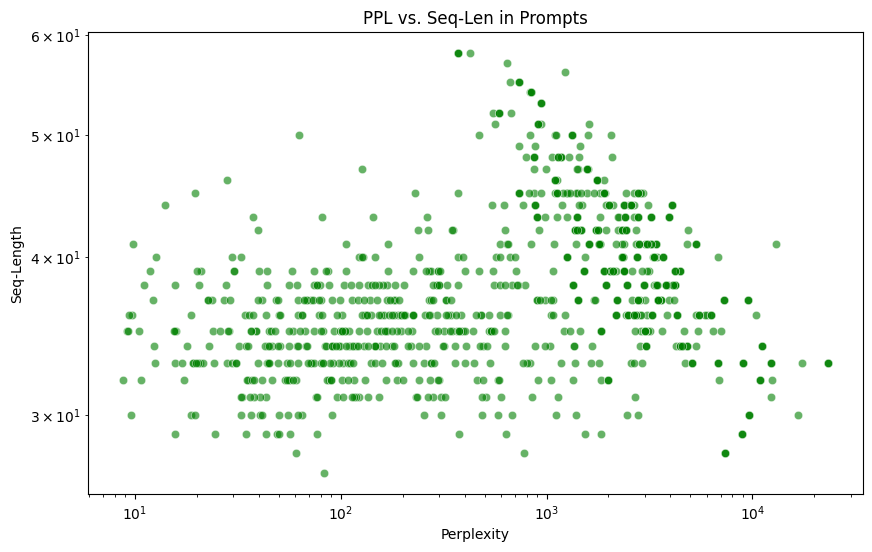

In [9]:
df=pd.concat([
    pd.read_csv(f'{DATASET_PATH}/viccuna_prompts.csv'),
    pd.read_csv(f'{DATASET_PATH}/adv_prompts.csv')])
df["Label"]=1
df_dict['Adversrial'] =df
plot_bin_graph(df_dict['Adversrial'])
plot_dot_graph(df_dict['Adversrial'], log_scale=True)

## Non adverserial prompts datasets

#### 1. DocRED

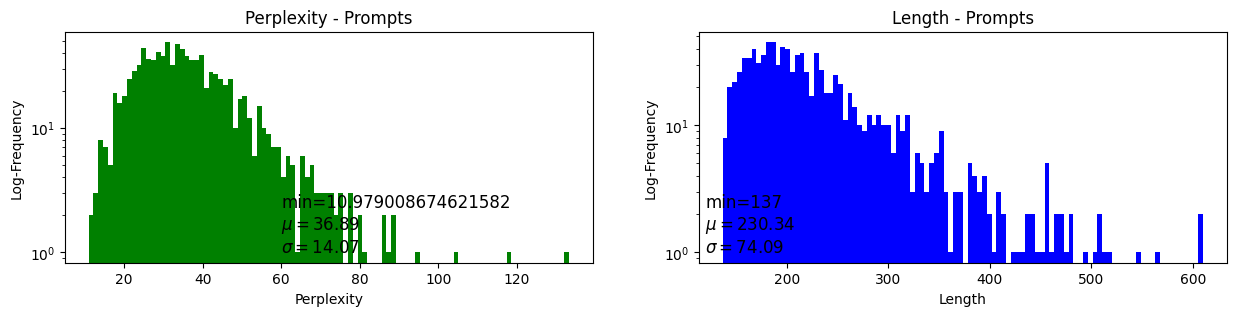

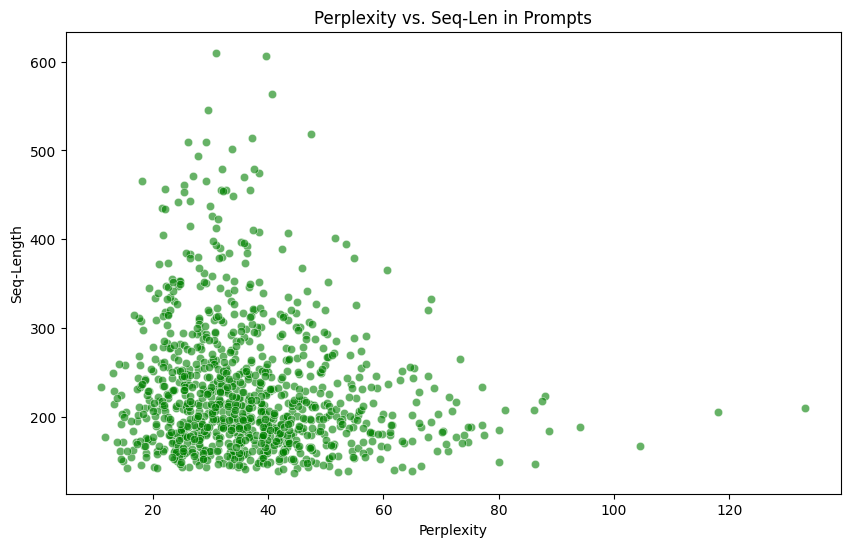

In [10]:
df_dict['dockred'] = pd.read_csv(f'{DATASET_PATH}/docred.csv')
df_dict['dockred']["Label"]=0
plot_bin_graph(df_dict['dockred'])
plot_dot_graph(df_dict['dockred'])

#### 2. Super Glue Boolq Dataset

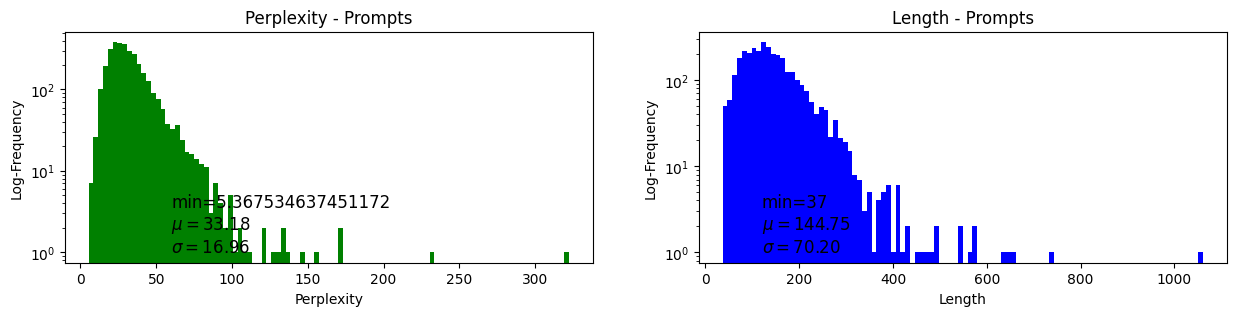

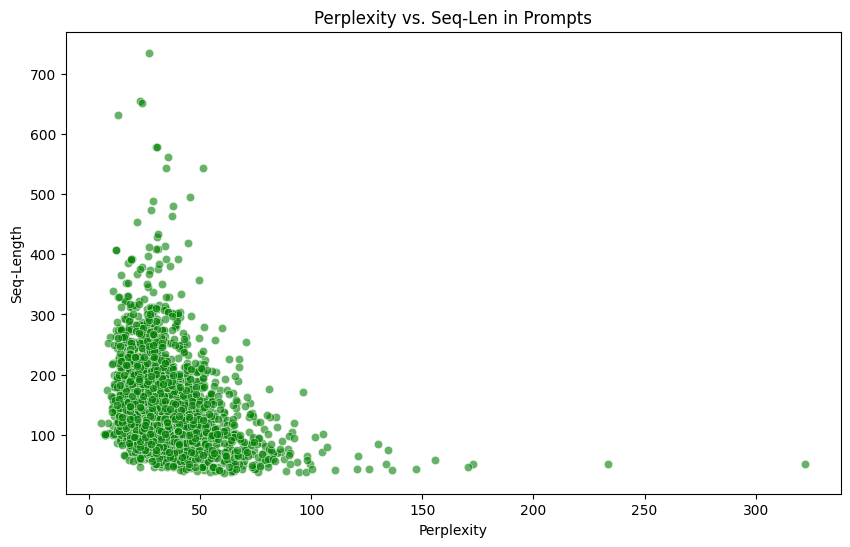

In [11]:
df_dict['boolq'] = pd.read_csv(f'{DATASET_PATH}/boolq.csv')
df_dict['boolq']["Label"]=0
plot_bin_graph(df_dict['boolq'])
plot_dot_graph(df_dict['boolq'])

#### 3. SuperGlueSquad V2 Dataset

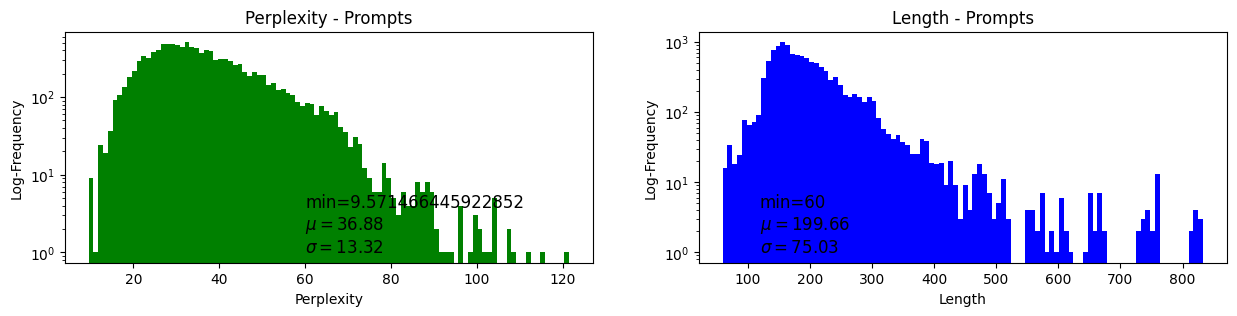

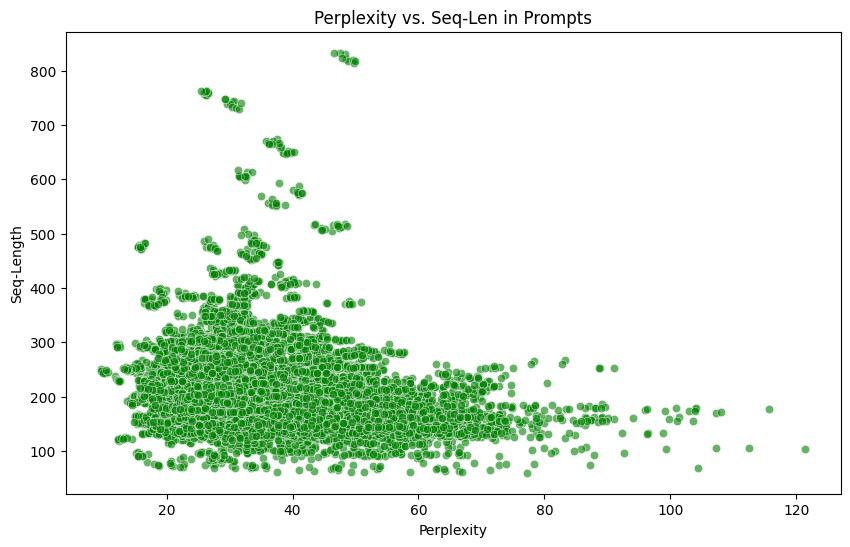

In [12]:
df_dict['super_glue_squad_v2'] = pd.read_csv(f'{DATASET_PATH}/super_glue_squad_v2.csv')
df_dict['super_glue_squad_v2']["Label"]=0
plot_bin_graph(df_dict['super_glue_squad_v2'])
plot_dot_graph(df_dict['super_glue_squad_v2'])

#### 4. Platypus Dataset

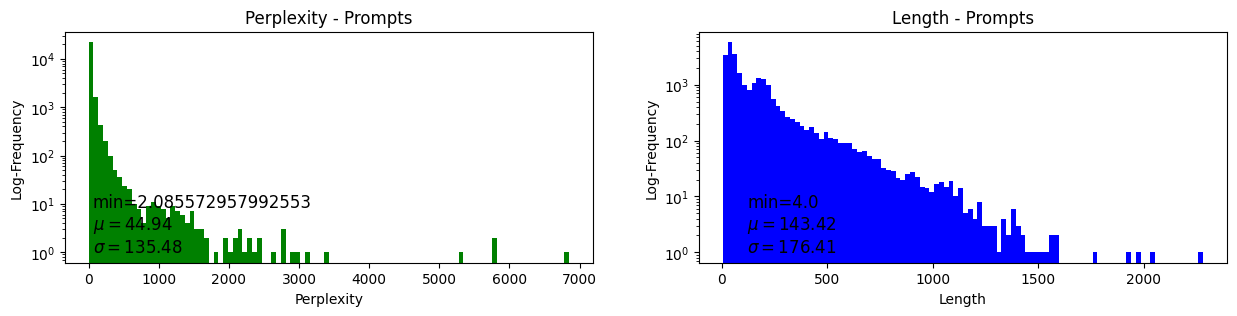

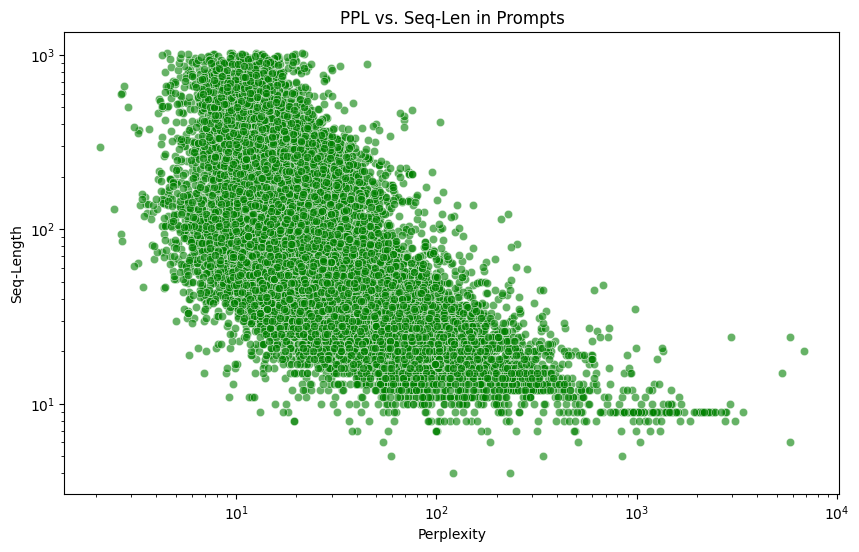

In [13]:
df_dict['platypus'] = pd.read_csv(f'{DATASET_PATH}/platypus.csv')
df_dict['platypus']["Label"]=0
plot_bin_graph(df_dict['platypus'])
plot_dot_graph(df_dict['platypus'], log_scale=True)

#### 5. Puffin Dataset

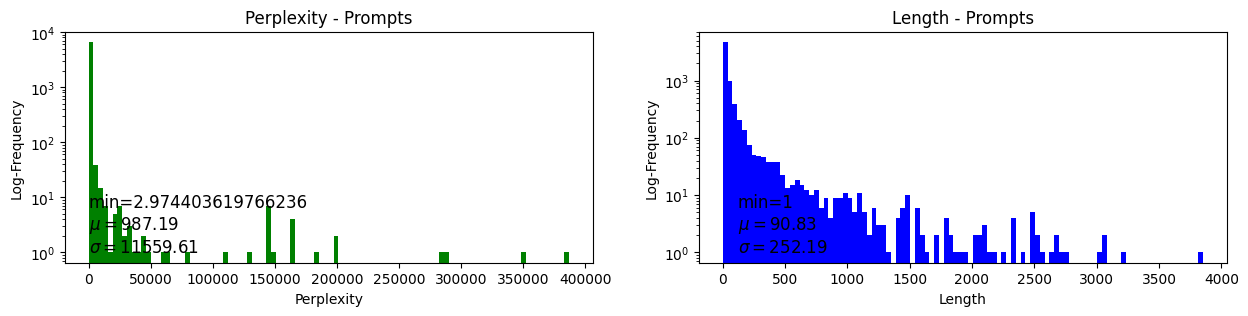

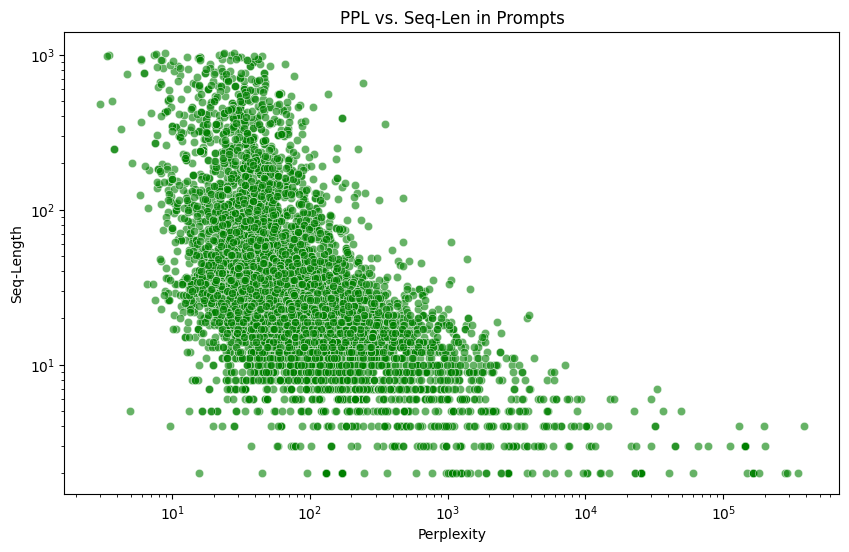

In [14]:
df_dict['puffin'] = pd.read_csv(f'{DATASET_PATH}/puffin.csv')
df_dict['puffin']["Label"]=0
plot_bin_graph(df_dict['puffin'])
plot_dot_graph(df_dict['puffin'], log_scale=True)

#### 6. Tapir Dataset

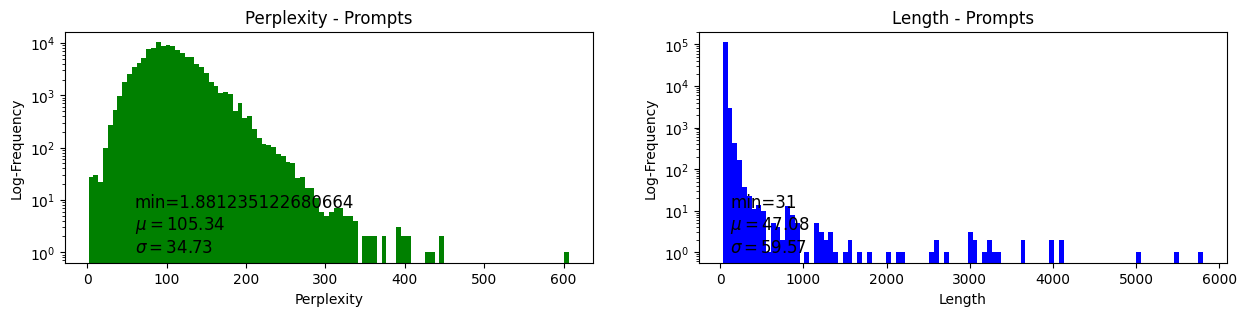

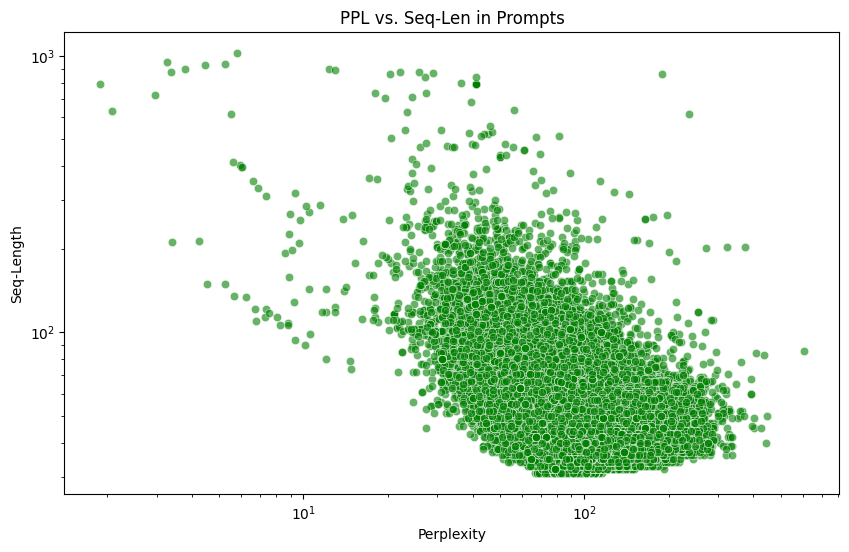

In [15]:
df_dict['tapir'] = pd.read_csv(f'{DATASET_PATH}/tapir.csv')
df_dict['tapir']["Label"]=0
plot_bin_graph(df_dict['tapir'])
plot_dot_graph(df_dict['tapir'], log_scale=True)

#### 7. Code Dataset
Question Answering into Domain of code.

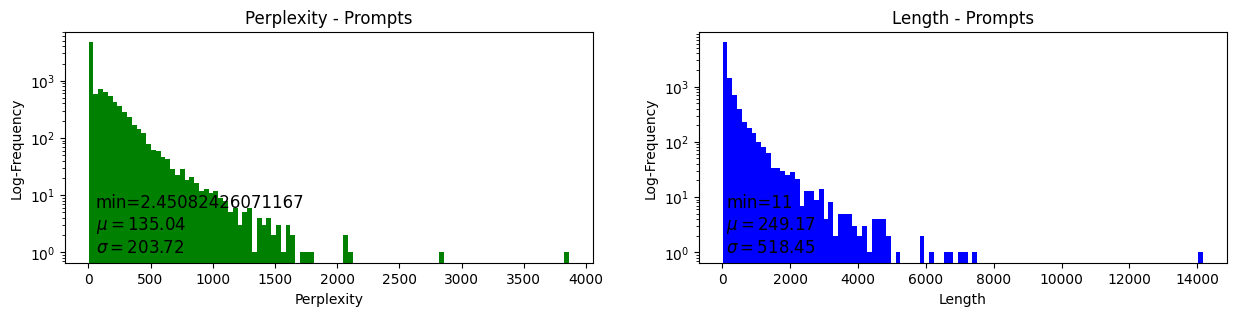

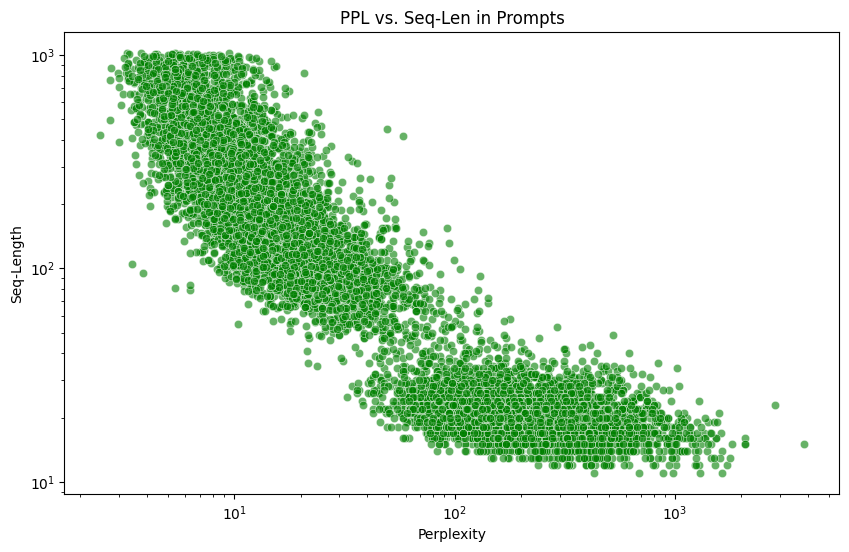

In [16]:
df_dict['code'] = pd.read_csv(f'{DATASET_PATH}/code.csv')
df_dict['code']["Label"]=0
plot_bin_graph(df_dict['code'])
plot_dot_graph(df_dict['code'], log_scale=True)

### Compare Adverserial vs non adversial datasets

In [17]:
df=pd.concat(list(df_dict.values()))[["Text","Length","Perplexity","Label"]]
df=df.dropna()

In [18]:
def plot_dot_graph_by_label(df, *, log_scale: bool = False):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df[df["Label"]==0], x='Perplexity', y='Length', color='green', alpha=0.6)
    sns.scatterplot(data=df[df["Label"]==1], x='Perplexity', y='Length', color='red', alpha=0.6)

    # Title and labels
    plt.title('Perplexity vs. Seq-Len in Prompts')
    plt.xlabel('Perplexity')
    plt.ylabel('Seq-Length')
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Seq-Length')
        plt.title('PPL vs. Seq-Len in Prompts')
    # Show the plot
    plt.show()


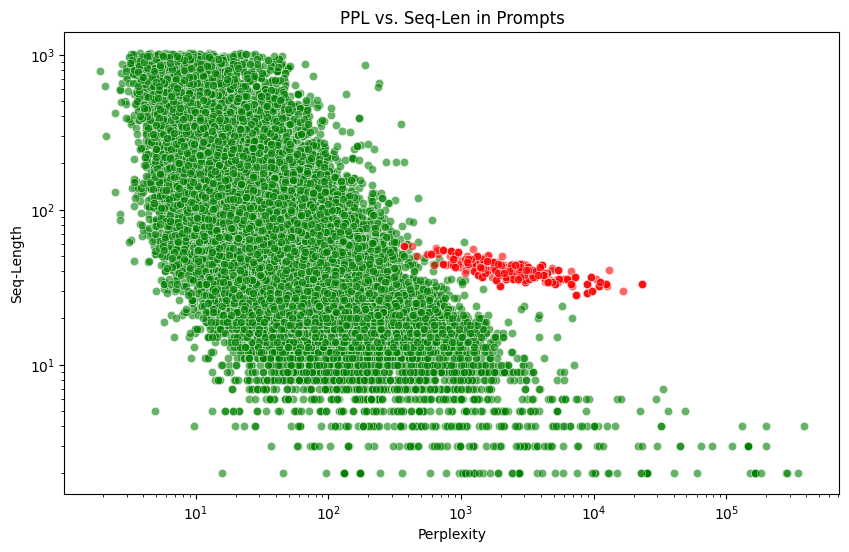

In [19]:
plot_dot_graph_by_label(df, log_scale=True)

### Classifiers

In [30]:
estimators = [
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree",DecisionTreeClassifier()),
    ("Support Vector Machine", svm.SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("decision tree",DecisionTreeClassifier(random_state=42)),
    ("KNeighborsClassifier",KNeighborsClassifier(2)),
    ("AdaBoostClassifier",AdaBoostClassifier()),
    ("XGBClassifier",XGBClassifier()),
    ("LGBMClassifier",LGBMClassifier()),
]

In [31]:
# Import performance metrics libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(df[["Perplexity","Length"]]), list(df["Label"]), test_size=0.2, random_state=42)


# Prepare a DataFrame to keep track of the models' performance
results = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1 score","f beta"])

# Iterate through each estimator in the list
for est_name, est_obj in estimators:

    # Fit the model
    est_obj.fit(X_train, y_train)

    # Use the model to predict unseen prompts
    y_predict = est_obj.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fbeta = fbeta_score(y_test, y_predict,beta=BETA)
    f1 = f1_score(y_test, y_predict)

    # Store performance metrics
    results.loc[est_name] = [accuracy, precision, recall, f1,fbeta]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Info] Number of positive: 314, number of negative: 139114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 139428, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002252 -> initscore=-6.093656
[LightGBM] [Info] Start training from score -6.093656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [32]:
results

,accuracy,precision,recall,f1 score,f beta
QDA,0.997418,0.357143,0.058140,0.100000,0.069832
Naive Bayes,0.997418,0.333333,0.046512,0.081633,0.056180
Logistic Regression,0.997533,0.000000,0.000000,0.000000,0.000000
Decision Tree,0.999857,0.976471,0.965116,0.970760,0.967366
Support Vector Machine,0.997762,0.568966,0.383721,0.458333,0.410448
Random Forest,0.999943,0.988372,0.988372,0.988372,0.988372
decision tree,0.999914,0.988235,0.976744,0.982456,0.979021
KNeighborsClassifier,0.999541,0.948718,0.860465,0.902439,0.876777
AdaBoostClassifier,0.999914,0.977011,0.988372,0.982659,0.986079
XGBClassifier,0.999914,0.977011,0.988372,0.982659,0.986079
